## SVM + HOG

In [18]:
# Import modules
from cv2 import (imshow, waitKey, HOGDescriptor, SIFT_create, BOWKMeansTrainer,
                 BOWImgDescriptorExtractor, BFMatcher, NORM_L2, cvtColor, COLOR_RGB2GRAY, imread, IMREAD_GRAYSCALE)
from numpy import uint8, array, reshape, hsplit, vsplit
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import random
from sklearn import svm
from sklearn.model_selection import train_test_split
import time

In [19]:
def build_img_array_from_path(path):
    files = Path(path).glob('*')
    # array_imgs = array([])
    array_imgs = []
    for fn in sorted(files):
        img = imread(str(fn), IMREAD_GRAYSCALE)
        img_prep = np.array(img)
        # array_imgs = np.append(array_imgs, img)
        array_imgs.append(img_prep)

    return array_imgs

In [20]:
def hog_descriptors(imgs, size, winSizeVar, blockSizeVar, cellSizeVar):
    # Create a list to store the HOG feature vectors
    hog_features = []

    # Set parameter values for the HOG descriptor based on the image data in use
    winSize = (winSizeVar, winSizeVar)
    blockSize = (blockSizeVar, blockSizeVar)
    blockStride = (int(blockSizeVar / 2), int(blockSizeVar / 2))
    cellSize = (cellSizeVar, cellSizeVar)
    nbins = 9

    # Set the remaining parameters to their default values
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = False
    nlevels = 64

    # Create a HOG descriptor
    hog = HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma,
                        histogramNormType, L2HysThreshold, gammaCorrection, nlevels)

    # Compute HOG descriptors for the input images and append the feature vectors to the list
    for img in imgs:
        hist = hog.compute(img.reshape(size, size).astype(uint8))
        hog_features.append(hist)

    return array(hog_features)

In [21]:
def hog_visualization(img, descriptor, winSizeVar, blockSizeVar, cellSizeVar):
    winSize = (winSizeVar, winSizeVar)
    blockSize = (blockSizeVar, blockSizeVar)
    blockStride = (int(blockSizeVar / 2), int(blockSizeVar / 2))
    cell_size = (cellSizeVar, cellSizeVar)
    num_bins = 9

    print(blockStride)

    # Reshape the feature vector to [number of blocks in x and y direction, number of cells per block in x and y direction, number of bins]
    # This will be useful later when we plot the feature vector, so that the feature vector indexing matches the image indexing
    n_blockx = (winSize[0] // blockStride[0]) - 1
    n_blocky = (winSize[1] // blockStride[1]) - 1
    n_cellx = blockSize[0] // cell_size[0]
    n_celly = blockSize[1] // cell_size[1]

    hog_descriptor_reshaped = descriptor.reshape(n_blockx,
                                                 n_blocky,
                                                 n_cellx,
                                                 n_celly,
                                                 num_bins).transpose((1, 0, 2, 3, 4))

    # Create an array that will hold the average gradients for each cell
    ave_grad = np.zeros((n_blockx + 1, n_blocky + 1, num_bins))

    # Create an array that will count the number of histograms per cell
    hist_counter = np.zeros((n_blockx + 1, n_blocky + 1, 1))

    # Add up all the histograms for each cell and count the number of histograms per cell
    for i in range(n_cellx):
        for j in range(n_celly):
            ave_grad[i:n_blockx + i,
            j:n_blocky + j] += hog_descriptor_reshaped[:, :, i, j, :]

            hist_counter[i:n_blockx + i,
            j:n_blocky + j] += 1

    # Calculate the average gradient for each cell
    # print(hist_counter)
    ave_grad /= hist_counter

    # Calculate the total number of vectors we have in all the cells.
    len_vecs = ave_grad.shape[0] * ave_grad.shape[1] * ave_grad.shape[2]

    # Create an array that has num_bins equally spaced between 0 and 180 degress in radians.
    deg = np.linspace(0, np.pi, num_bins, endpoint=False)

    # Each cell will have a histogram with num_bins. For each cell, plot each bin as a vector (with its magnitude
    # equal to the height of the bin in the histogram, and its angle corresponding to the bin in the histogram).
    # To do this, create rank 1 arrays that will hold the (x,y)-coordinate of all the vectors in all the cells in the
    # image. Also, create the rank 1 arrays that will hold all the (U,V)-components of all the vectors in all the
    # cells in the image. Create the arrays that will hold all the vector positons and components.
    U = np.zeros((len_vecs))
    V = np.zeros((len_vecs))
    X = np.zeros((len_vecs))
    Y = np.zeros((len_vecs))

    # Set the counter to zero
    counter = 0

    # Use the cosine and sine functions to calculate the vector components (U,V) from their maginitudes. Remember the
    # cosine and sine functions take angles in radians. Calculate the vector positions and magnitudes from the
    # average gradient array
    for i in range(ave_grad.shape[0]):
        for j in range(ave_grad.shape[1]):
            for k in range(ave_grad.shape[2]):
                U[counter] = ave_grad[i, j, k] * np.cos(deg[k])
                V[counter] = ave_grad[i, j, k] * np.sin(deg[k])

                X[counter] = (cell_size[0] / 2) + (cell_size[0] * i)
                Y[counter] = (cell_size[1] / 2) + (cell_size[1] * j)

                counter = counter + 1

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Display the image
    ax1.set(title='Grayscale Image')
    ax1.imshow(img, cmap='gray')

    # Plot the feature vector (HOG Descriptor)
    ax2.set(title='HOG Descriptor')
    ax2.quiver(Y, X, U, V, color='white', headwidth=0, headlength=0, scale_units='inches', scale=3)
    ax2.invert_yaxis()
    ax2.set_aspect(aspect=1)
    ax2.set_facecolor('black')

    plt.show()

In [22]:
sub_imgs = build_img_array_from_path("Images/RSSCN7/fResident")
sub_imgs_labels = [True] * len(sub_imgs)
sub_imgs_dataset = list(zip(sub_imgs, sub_imgs_labels))

sub_imgs_false = build_img_array_from_path("Images/RSSCN7/gParking")
sub_imgs_false_labels = [False] * len(sub_imgs)
sub_imgs_false_dataset = list(zip(sub_imgs_false, sub_imgs_false_labels))

sub_imgs_conc = sub_imgs_dataset + sub_imgs_false_dataset
random.shuffle(sub_imgs_conc)

In [53]:
# configuration
size = 400
winSizeVar = 400
#blockSizeRange = [100, 200]
blockSizeRange = [10, 20, 40, 50, 80, 100, 200, 400]
# blockSizeStart = 40
# blockSizeEnd = 400
# blockSizeStep = 40
cellSizeRatio = [1, 2, 5]

A_conc = []
A = np.array(['blocksizevar', 'hognumber', 'accuracy', 'time'])

#for step in range(blockSizeStart, blockSizeEnd, blockSizeStep):
for cell_zise in cellSizeRatio:
    for step in blockSizeRange:
        start_time = time.time()
        
        blockSizeVar = step
        cellSizeVar = step // cell_zise
    
        print(blockSizeVar)
        print(cellSizeVar)
        
        dataset = sub_imgs_conc
        
        validation_dataset = build_img_array_from_path("Images/RSSCN7_test")
        
        validation_data = []
        temp_list = []
        
        for validation in validation_dataset:
            descriptor = hog_descriptors([validation], size, winSizeVar, blockSizeVar, cellSizeVar)
            #print('Size of HOG feature vectors:', descriptor.shape)
            validation_data.append(descriptor[0])
        
        # Compute the HOG descriptors for the images
        #shog = cv2.HOGDescriptor()
        data = []
        labels = []
        
        for image, label in dataset:
            descriptor = hog_descriptors([image], size, winSizeVar, blockSizeVar, cellSizeVar)
            #print('Size of HOG feature vectors:', descriptor.shape)
            data.append(descriptor[0])
            labels.append(label)
        
        # Convert the data to a numpy array
        data = np.array(data)
        labels = np.array(labels)
        
        # Split the dataset into a training set and a test set
        data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.2, random_state=42)
        
        print('Shape of data_test:', data_train.shape)
        print('Shape of data_test:', data_test.shape)
        print('HOG number:', data_test.shape[1])
        #print('Shape of labels_train:',labels_train.shape)
        
        # Train the SVM
        clf = svm.SVC()
        clf.fit(data_train, labels_train)
        
        #print(data_test.shape)
        # Test the SVM
        labels_pred = clf.predict(data_test)
        
        labels_validation = clf.predict(validation_data)
        
        # Print the accuracy
        accuracy = np.sum(labels_pred == labels_test) / labels_test.shape[0]
        print('Accuracy: ', accuracy)
        
        print(labels_validation)
        spent_time = round((time.time() - start_time), 2)
        #print("--- %s seconds ---" % (time.time() - start_time))
        print(f'Spent time: {spent_time}')
    
    
        temp_list = temp_list + [blockSizeVar,data_test.shape[1],accuracy,spent_time]
        A = np.vstack([A, temp_list])
        temp_list = []
    A_conc.append(A)
    A = np.array(['blocksizevar', 'hognumber', 'accuracy', 'time'])
print(A_conc)

10
10
Shape of data_test: (640, 56169)
Shape of data_test: (160, 56169)
HOG number: 56169
Accuracy:  0.65
[ True  True False False  True False False False False]
Spent time: 29.37
20
20
Shape of data_test: (640, 13689)
Shape of data_test: (160, 13689)
HOG number: 13689
Accuracy:  0.7125
[False False False False  True False False False False]
Spent time: 44.66
40
40
Shape of data_test: (640, 3249)
Shape of data_test: (160, 3249)
HOG number: 3249
Accuracy:  0.73125
[False False False False  True False False False False]
Spent time: 2.09
50
50
Shape of data_test: (640, 2025)
Shape of data_test: (160, 2025)
HOG number: 2025
Accuracy:  0.74375
[False False False False  True False False False False]
Spent time: 1.78
80
80
Shape of data_test: (640, 729)
Shape of data_test: (160, 729)
HOG number: 729
Accuracy:  0.68125
[False False False False  True False False False False]
Spent time: 1.58
100
100
Shape of data_test: (640, 441)
Shape of data_test: (160, 441)
HOG number: 441
Accuracy:  0.65625

## Plot results

[ 10.  20.  40.  50.  80. 100. 200. 400.]
[0.65    0.7125  0.73125 0.74375 0.68125 0.65625 0.56875 0.5375 ]
[ 10.  20.  40.  50.  80. 100. 200. 400.]
[0.6625  0.6625  0.70625 0.7375  0.75    0.78125 0.7375  0.73125]
[ 10.  20.  40.  50.  80. 100. 200. 400.]
[0.6375  0.6375  0.65    0.675   0.6875  0.6875  0.7125  0.74375]


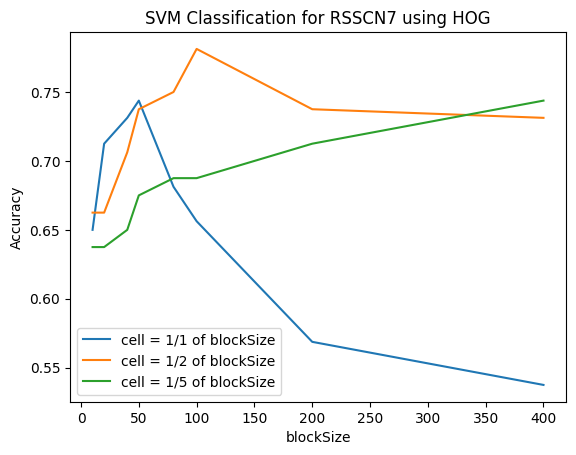

In [54]:
for i in range(0, len(A_conc)):
    image_label = f"cell = 1/{cellSizeRatio[i]} of blockSize"
    A = A_conc[i]
    x = A[1:, 0].astype(float)
    y = A[1:, 2].astype(float)

    print(x)
    print(y)
    plt.title(f"SVM Classification for RSSCN7 using HOG")
    plt.xlabel("blockSize")
    plt.ylabel("Accuracy") 
    plt.plot(x,y, label = image_label)
    
# Last group of graphs        
#plt.gca().invert_xaxis()
plt.legend()
plt.show()

[ 10.  20.  40.  50.  80. 100. 200. 400.]
[5.6169e+04 1.3689e+04 3.2490e+03 2.0250e+03 7.2900e+02 4.4100e+02
 8.1000e+01 9.0000e+00]
[ 10.  20.  40.  50.  80. 100. 200. 400.]
[2.24676e+05 5.47560e+04 1.29960e+04 8.10000e+03 2.91600e+03 1.76400e+03
 3.24000e+02 3.60000e+01]
[ 10.  20.  40.  50.  80. 100. 200. 400.]
[1.404225e+06 3.422250e+05 8.122500e+04 5.062500e+04 1.822500e+04
 1.102500e+04 2.025000e+03 2.250000e+02]


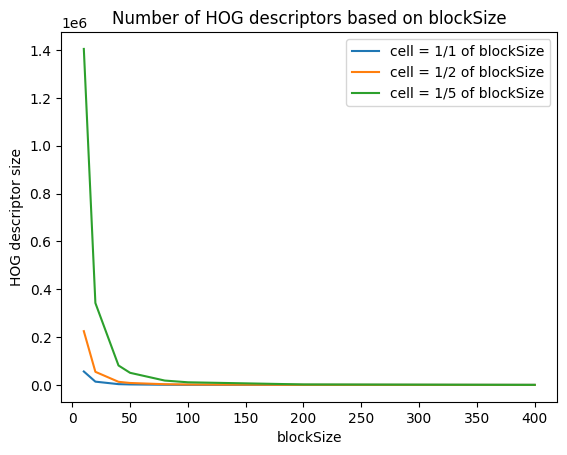

In [56]:
for i in range(0, len(A_conc)):
    image_label = f"cell = 1/{cellSizeRatio[i]} of blockSize"
    A = A_conc[i]
    x = A[1:, 0].astype(float)
    y = A[1:, 1].astype(float)

    print(x)
    print(y)
    plt.title(f"Number of HOG descriptors based on blockSize")
    plt.xlabel("blockSize")
    plt.ylabel("HOG descriptor size") 
    plt.plot(x,y, label = image_label)
    
# Last group of graphs        
#plt.gca().invert_xaxis()
plt.legend()
plt.show()

[ 10.  20.  40.  50.  80. 100. 200. 400.]
[29.37 44.66  2.09  1.78  1.58  1.56  1.64  2.99]
[ 10.  20.  40.  50.  80. 100. 200. 400.]
[129.04  24.59  66.08   3.13   2.33   2.03   2.26   3.57]
[ 10.  20.  40.  50.  80. 100. 200. 400.]
[635.   125.71  36.13  29.12  19.19  19.08   3.13   4.2 ]


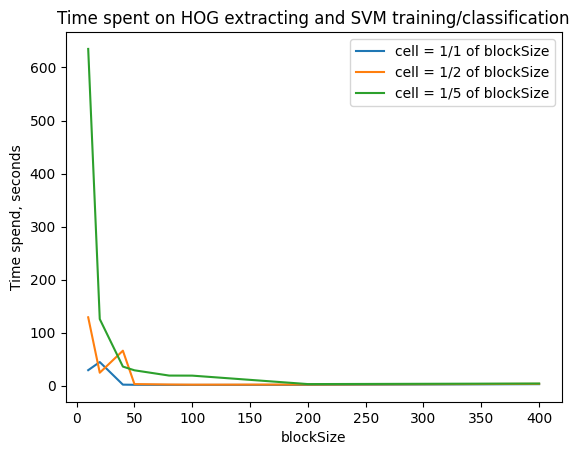

In [57]:
for i in range(0, len(A_conc)):
    image_label = f"cell = 1/{cellSizeRatio[i]} of blockSize"
    A = A_conc[i]
    x = A[1:, 0].astype(float)
    y = A[1:, 3].astype(float)

    print(x)
    print(y)
    plt.title(f"Time spent on HOG extracting and SVM training/classification")
    plt.xlabel("blockSize")
    plt.ylabel("Time spend, seconds") 
    plt.plot(x,y, label = image_label)
    
# Last group of graphs        
#plt.gca().invert_xaxis()
plt.legend()
plt.show()